<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification
Classification, that is deciding the class membership of a datapoint depending on its attributes, is one of the main application of neural networks. As an example we will build a binary classifier to determine the type of review of movies based on the content: positive or negative. For this exercise we'll use the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/), a set of 50k reviews divided in 25k for training and 25k for validation. Each dataset, train and validation, is split in 50% positive and 50% negative reviews. Each word in the reviews has been mapped into an integer value so that each review is represented by an array of integers in a vector space. The The dataset can be dowloaded directly through Tensorflow. We will use only the first 10k more frequent words. This allows us represent each review as a vector in a space of dimensionality 10k.


In [5]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

Each review is represented as an array of integers from 0 to 9999.

In [6]:
print(train_data[0][0:20])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]


We can revert the representation of a review from an array of integers back to a sequence of words using the dictionary

In [7]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review_0 = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])

In [8]:
len(decoded_review_0.split())

218

The lenght of the array depends on the number of words in the review

In [9]:
len(train_data[0])

218

## Multi-hot encode
The network accepts a batch of reviews all of the same size. One way to represent a review is to use the multi-hot encode for which each review is represented by the unique words in the dictionary that have been used at least once. For example if a review is represented by the array [2, 100, 564] we will use a multi-hot representation of dimensionality 10k setting the values at index 2, 100, and 564 to 1 and the rest left to its default value 0. The space of dimensionality 10k is called embedding space. We define a function to multi-hot encode the reviews  

In [10]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [11]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
x_train.shape, x_test.shape

((25000, 10000), (25000, 10000))

In [12]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
y_train.shape, y_test.shape

((25000,), (25000,))

## A binary classifier
Learning how to classify an array between two classes can be solved using a stack of fully connected layers whose output will be 1 or 0. The question is how many layers and how many units in each layer. We can start with a network of three layers. The first two layers with 16 units and the [Rectified Linear Unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) (ReLU) activation function, and the last one with only one unit with the [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function. The layers with the ReLU activation function implement the function

$$o = ReLU(Wx + b)$$

where W represents the weights of the layer, that is a matrix of (10000 x 16) elements. The weight matrix W projects a vector from the input space into the representation space of dimensionality 16, much smaller than the input space. The sigmoid function maps an input value into an interval [0, 1] so that it can be interpreted as a probability for 0 or 1.

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
  layers.Dense(16, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

We have to choose the loss function and the optimizer. Since we are dealing with a binary classification we use the [binary crossentropy](https://en.wikipedia.org/wiki/Cross-entropy) loss function. In few words, we want to minimize the distance between the probability distributions of words in the input space and in the target space. For the optimizer we use [RMSprop](https://keras.io/api/optimizers/rmsprop/), similar to gradient descent.

In [14]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

We use 10k reviews for validation and the remaining 15k for training

In [15]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We train the model for 20 epochs

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 3s 84ms/step - loss: 0.5540 - accuracy: 0.7668 - val_loss: 0.4261 - val_accuracy: 0.8662
Epoch 2/20
30/30 [==============================] - 2s 52ms/step - loss: 0.3486 - accuracy: 0.8889 - val_loss: 0.3321 - val_accuracy: 0.8812
Epoch 3/20
30/30 [==============================] - 1s 38ms/step - loss: 0.2599 - accuracy: 0.9151 - val_loss: 0.2956 - val_accuracy: 0.8853
Epoch 4/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2082 - accuracy: 0.9317 - val_loss: 0.2913 - val_accuracy: 0.8842
Epoch 5/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1744 - accuracy: 0.9435 - val_loss: 0.2980 - val_accuracy: 0.8812
Epoch 6/20
30/30 [==============================] - 1s 33ms/step - loss: 0.1481 - accuracy: 0.9519 - val_loss: 0.2840 - val_accuracy: 0.8858
Epoch 7/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1276 - accuracy: 0.9589 - val_loss: 0.3095 - val_accuracy: 0.8781
Epoch 8/20
30

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Model performance
We can visualize the loss and the accuracy for the training and validation datasets. What we care about is the performance on the validation set that measures the generalization skill of the model. As we can see, there is a minimum loss at the 6th epoch and after it increases again while on the training set it continues to fall, a clear sign of overfitting. One option to avoid overfitting is to stop the training at the 6th epoch.

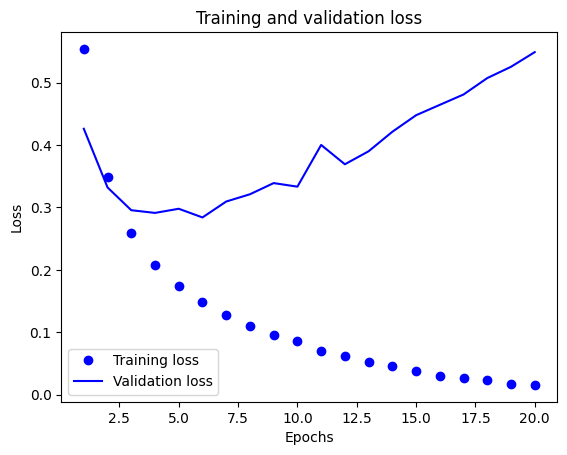

In [14]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

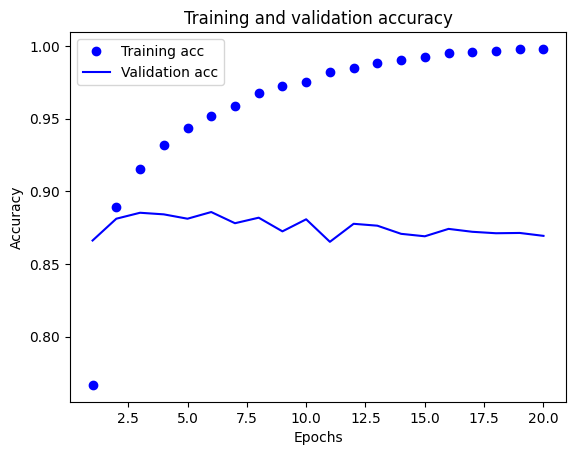

In [15]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
model.predict(x_test)

782/782 [==============================] - 4s 4ms/step


array([[0.02081073],
       [1.        ],
       [0.7353399 ],
       ...,
       [0.00570623],
       [0.01523276],
       [0.95202506]], dtype=float32)

We train the same model for 6 epochs

In [16]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=6,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/6
30/30 [==============================] - 4s 94ms/step - loss: 0.5247 - accuracy: 0.7582 - val_loss: 0.3742 - val_accuracy: 0.8710
Epoch 2/6
30/30 [==============================] - 1s 36ms/step - loss: 0.3062 - accuracy: 0.8977 - val_loss: 0.3018 - val_accuracy: 0.8861
Epoch 3/6
30/30 [==============================] - 1s 36ms/step - loss: 0.2217 - accuracy: 0.9282 - val_loss: 0.2790 - val_accuracy: 0.8868
Epoch 4/6
30/30 [==============================] - 1s 34ms/step - loss: 0.1848 - accuracy: 0.9373 - val_loss: 0.2759 - val_accuracy: 0.8881
Epoch 5/6
30/30 [==============================] - 1s 34ms/step - loss: 0.1462 - accuracy: 0.9527 - val_loss: 0.2826 - val_accuracy: 0.8849
Epoch 6/6
30/30 [==============================] - 1s 36ms/step - loss: 0.1254 - accuracy: 0.9583 - val_loss: 0.2966 - val_accuracy: 0.8841


In [17]:
predictions = model.predict(x_test)

782/782 [==============================] - 2s 2ms/step


In [19]:
predictions.max()

0.9999999